3d densenet

In [14]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import cv2
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

In [15]:
# Constants
DATA_DIR = 'Data/'  # Update this to your data directory
LABELS_CSV = 'LungCT-Labels - Sheet1.csv'  # Update this to your labels file
IMG_SIZE_PX = 150
SLICE_COUNT = 20

In [16]:
# Function to create a Dense Block
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        # Bottleneck layer
        bn = layers.BatchNormalization()(x)
        relu = layers.Activation('relu')(bn)
        conv = layers.Conv3D(4 * growth_rate, kernel_size=1, padding='same')(relu)
        
        # 3D convolution layer
        bn = layers.BatchNormalization()(conv)
        relu = layers.Activation('relu')(bn)
        conv = layers.Conv3D(growth_rate, kernel_size=3, padding='same')(relu)
        
        # Concatenate input with the output of the convolution layer
        x = layers.Concatenate()([x, conv])
    return x

In [17]:
# Function to create a Transition Layer
def transition_layer(x, compression):
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(int(x.shape[-1] * compression), kernel_size=1, padding='same')(x)
    x = layers.AveragePooling3D(pool_size=2, strides=2, padding='same')(x)
    return x

In [18]:
# Function to build the 3D DenseNet model
def build_densenet3d(input_shape=(SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1), num_classes=2, growth_rate=32, compression=0.5):
    inputs = Input(shape=input_shape)
    
    # Initial Convolution and Pooling
    x = layers.Conv3D(64, kernel_size=7, strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling3D(pool_size=3, strides=2, padding='same')(x)
    
    # Dense Blocks with Transition Layers
    x = dense_block(x, num_layers=6, growth_rate=growth_rate)
    x = transition_layer(x, compression=compression)
    
    x = dense_block(x, num_layers=12, growth_rate=growth_rate)
    x = transition_layer(x, compression=compression)
    
    x = dense_block(x, num_layers=24, growth_rate=growth_rate)
    x = transition_layer(x, compression=compression)
    
    x = dense_block(x, num_layers=16, growth_rate=growth_rate)
    
    # Global Average Pooling and Output Layer
    x = layers.GlobalAveragePooling3D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [19]:
# Function to load and preprocess data
def load_data(data_dir, labels_df, img_size_px=IMG_SIZE_PX, hm_slices=SLICE_COUNT):
    image_full_data = []
    
    patients = os.listdir(data_dir)

    for patient in patients:
        label = labels_df.at[patient, 'Labels']
        path = os.path.join(data_dir, patient)
        slices = [dicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
        slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array), (img_size_px, img_size_px)) for each_slice in slices]
        
        chunk_sizes = math.ceil(len(slices) / hm_slices)
        for i in range(0, len(slices), chunk_sizes):
            slice_chunk = slices[i:i + chunk_sizes]
            if len(slice_chunk) > 0:
                new_slices.append(np.mean(slice_chunk, axis=0))

        if len(new_slices) < hm_slices:
            last_slice = new_slices[-1]
            while len(new_slices) < hm_slices:
                new_slices.append(last_slice)

        image_full_data.append([new_slices, np.array([1, 0]) if label == 1 else np.array([0, 1])])

    return image_full_data

In [20]:
# Load labels
labels_df = pd.read_csv(LABELS_CSV, index_col=0)

# Load and preprocess data
image_full_data = load_data(DATA_DIR, labels_df)


In [21]:
# Shuffle and split data into training and validation sets
np.random.shuffle(image_full_data)
train_data = image_full_data[:int(len(image_full_data) * 0.8)]
validation_data = image_full_data[int(len(image_full_data) * 0.8):]

train_X = np.array([data[0] for data in train_data])
train_Y = np.array([data[1] for data in train_data])
valid_X = np.array([data[0] for data in validation_data])
valid_Y = np.array([data[1] for data in validation_data])


In [22]:
# Reshape data for model input
train_X = train_X.reshape((-1, SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))
valid_X = valid_X.reshape((-1, SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))


In [23]:
# Build the DenseNet3D model
model = build_densenet3d(input_shape=(SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))


In [24]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
# Summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20, 150,   │          0 │ -                 │
│ (InputLayer)        │ 150, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_120 (Conv3D) │ (None, 10, 75,    │     22,016 │ input_layer_1[0]… │
│                     │ 75, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 5, 38, 38, │          0 │ conv3d_120[0][0]  │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 38, 38, │        256 │ max_pooling3d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_119      │ (None, 5, 38, 38, │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_121 (Conv3D) │ (None, 5, 38, 38, │      8,320 │ activation_119[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 38, 38, │        512 │ conv3d_121[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_120      │ (None, 5, 38, 38, │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_122 (Conv3D) │ (None, 5, 38, 38, │    110,624 │ activation_120[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_58      │ (None, 5, 38, 38, │          0 │ max_pooling3d_1[… │
│ (Concatenate)       │ 96)               │            │ conv3d_122[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 38, 38, │        384 │ concatenate_58[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_121      │ (None, 5, 38, 38, │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_123 (Conv3D) │ (None, 5, 38, 38, │     12,416 │ activation_121[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 38, 38, │        512 │ conv3d_123[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_122      │ (None, 5, 38, 38, │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_124 (Conv3D) │ (None, 5, 38, 38, │    110,624 │ activation_122[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_59      │ (None, 5, 38, 38, │          0 │ concatenate_58[0

 Total params: 11,334,210 (43.24 MB)

 Trainable params: 11,252,738 (42.93 MB)

 Non-trainable params: 81,472 (318.25 KB)

In [26]:
# Fit the model and store training history
history = model.fit(train_X, train_Y, batch_size=5, epochs=10, validation_data=(valid_X, valid_Y))


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 180s 7s/step - accuracy: 0.4674 - loss: 3.3693 - val_accuracy: 0.3846 - val_loss: 16573.3867
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.4442 - loss: 1.3607 - val_accuracy: 0.6154 - val_loss: 63370.8164
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.6018 - loss: 1.0179 - val_accuracy: 0.3846 - val_loss: 851.7490
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.4929 - loss: 0.9545 - val_accuracy: 0.3846 - val_loss: 217.9330
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.5535 - loss: 0.6624 - val_accuracy: 0.6154 - val_loss: 42.5345
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.5492 - loss: 0.6281 - val_accuracy: 0.6154 - val_loss: 33.8808
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - accuracy: 0.6141 - loss: 0.8081 - val_accuracy: 0.6154 - val_loss: 29.6710
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step - accuracy: 0.5314 - loss: 0.8455 - val_accuracy: 0.

In [27]:
# Save the model
model.save("densenet3d_model.h5")

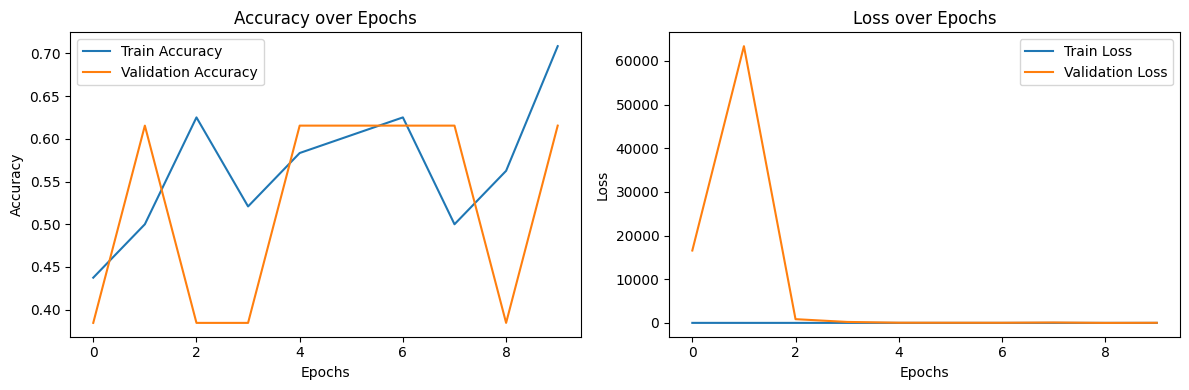

In [28]:
# Plotting the training and validation accuracy and loss
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_history(history)